In this notebook, we are going to illustrate to construct a free energy profile from WHAM as well as the additional information required to compute a reaction rate from transition state theory.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, plot_feps
from thermolib.thermodynamics.histogram import Histogram1D, plot_histograms
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.trajectory import CVComputer, ColVarReader
from thermolib.thermodynamics.cv import CoordinationNumber, LinearCombination
from thermolib.kinetics.rate import RateFactorEquilibrium

import numpy as np, matplotlib.pyplot as pp, time, os

from molmod.units import *
from molmod.constants import *

In [3]:
prefix = 'basic_kinetic_'
fn_meta = 'data/formic_acid_dimer_link/wham_input.txt'

# WHAM profile

We first construct the WHAM 1D free energy profile.
STEP 1 - read trajectories

In [4]:
colvar_reader = ColVarReader([0], units=['au'])
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)

STEP2 - estimate correlation times

In [5]:
corrtimes = decorrelate(trajectories)

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


STEP 3 - construct FEP accounting for the MD correlation time as well as covariance between FEP points

In [ ]:
bins = np.arange(-1.55, 1.55, 0.01)
hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)

In [ ]:
fep = SimpleFreeEnergyProfile.from_histogram(hist, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep.process_states(lims=[-1.5,-0.2,0.2,1.5], verbose=True)
fep.set_ref(ref='r')

In [ ]:
fep.plot(flims=[-5,30])

# Rate constant

The rate from transition state theory is defined as:

\begin{align}
    k^{TST} = A \frac{e^{-\beta F(q^{TS})}}{\int e^{-\beta F(q)}dq}
\end{align}

with

\begin{align}
    A = \sqrt{\frac{1}{2\pi\beta}}\left\langle \left|\vec{\nabla}_x Q\right| \right\rangle_{TS}
\end{align}

The second factor in $k^{TST}$ can be extracted purely from the free energy profile, however, the $A$ factor requires additional information extracted from simulations that samples the transition state. This is the first thing we will need to do.

To this end, we first define the collective variable used for the construction of the FEP

In [6]:
#CV definition
C1 = CoordinationNumber([[0,9]], r0=1.4*angstrom)
C2 = CoordinationNumber([[7,9]], r0=1.4*angstrom)
C3 = CoordinationNumber([[2,4]], r0=1.4*angstrom)
C4 = CoordinationNumber([[5,4]], r0=1.4*angstrom)
CV = LinearCombination([C1,C2,C3,C4], [1., -1., -1., 1.])

To extract the rate prefactor A from simulation trajectories (possibly biased) around the transition state, we first make an educated guess of which umbrella sampling trajectories are indeed around the TS and plot a histogram of these trajectories to double check before we continue.

In [ ]:
fns = ['%s/colvars/u%i.xyz' %(os.path.dirname(fn_meta),i) for i in range(61,68)]
labels = [fn.split('/')[-1] for fn in fns]
hists = []
bins = np.arange(-0.15, 0.15, 0.001)
cv_comp = CVComputer([CV])
for fn in fns:
    cv_data = cv_comp(fn)
    hist = Histogram1D.from_single_trajectory(cv_data, bins)
    hists.append(hist)
plot_histograms(hists, labels=labels)

We are going to chose the trajectory `u64.xyz` as it has a high probabilty around the transition state (which is around 0.0). We could also use multiple trajectory (e.g. `u63.xyz` and `u64.xyz`), but that will not allow to use block averaging to estimate correlation time and error.

We initialize a RateFactor instance for an Equilibrium simulation (eg. umbrella around TS). For this, we need to associate a width to the CV value in the transition state to allow for defining a dirac function and extracting TS states from the trajectories determined above. We do this by setting a CV_TS_lims interval around the TS using the user specified CV_TS_Delta. From the histogram above, we choose CV_TS_Delta as 0.01, meaning that basically the interval [-0.01,0.01] will be recognized ad the TS.

In [ ]:
CV_TS_Delta = 0.01
CV_TS_lims = [fep.ts.get_cv()-CV_TS_Delta, fep.ts.get_cv()+CV_TS_Delta]
rate = RateFactorEquilibrium(CV, CV_TS_lims, temp, CV_unit='au')

Now we read all TS samples from the above determined trajectory and compute the corresponding A factor values.

In [ ]:
fn = '%s/colvars/u64.xyz' %os.path.dirname(fn_meta)
rate.process_trajectory(fn, finish=False, momenta='analytical', verbose=True)
rate.finish(fn=prefix+'rate_factor_samples.txt')

Use the extracted samples to compute the TS-constrained ensemble average of the rate prefactor (i.e. the A factor) and use block averaging to estimate correlation time and error bar.

In [ ]:
A, A_dist = rate.result_blav(plot=True, fitrange=[1,300])

Compute rate and its error

In [ ]:
rate_results = rate.compute_rate(fep, verbose=True)

Finally, we make a summarizing plot with all FEP thermodynamics and all rate kinetics.

In [ ]:
fep.plot(rate=rate, do_latex=False, fn='basic_kinetics.pdf')

In [13]:
bins = np.arange(-1.55, 1.55, 0.01)
hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, Nscf=10000)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.087s
  bias poten. : 00h 00m 00.036s
  solve scf   : 00h 00m 00.466s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.590s
---------------------------------------------------------------------


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


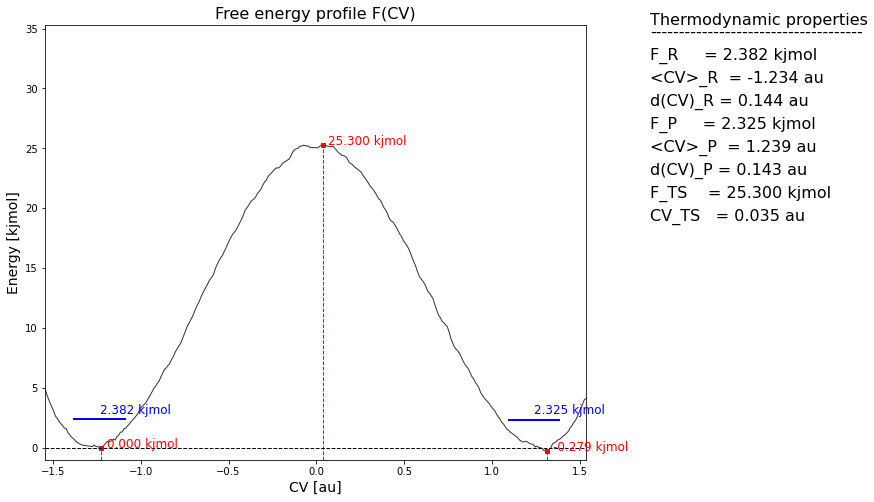

In [20]:
fep = SimpleFreeEnergyProfile.from_histogram(hist, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep.process_states(lims=[-1.5,-0.2,0.2,1.5])
fep.set_ref(ref='r')
fep.plot()

In [16]:
CV_TS_Delta = 0.01
CV_TS_lims = [fep.ts.get_cv()-CV_TS_Delta, fep.ts.get_cv()+CV_TS_Delta]
rate = RateFactorEquilibrium(CV, CV_TS_lims, temp, CV_unit='au')

In [17]:
fn = '%s/colvars/u64.xyz' %os.path.dirname(fn_meta)
rate.process_trajectory(fn, finish=False, momenta='analytical', verbose=True)
rate.finish(fn=prefix+'rate_factor_samples.txt')

Estimating rate factor from trajectory data/formic_acid_dimer_link/colvars/u64.xyz for TS=[0.025,0.045] au using analytical momentum integration


<Figure size 432x288 with 0 Axes>

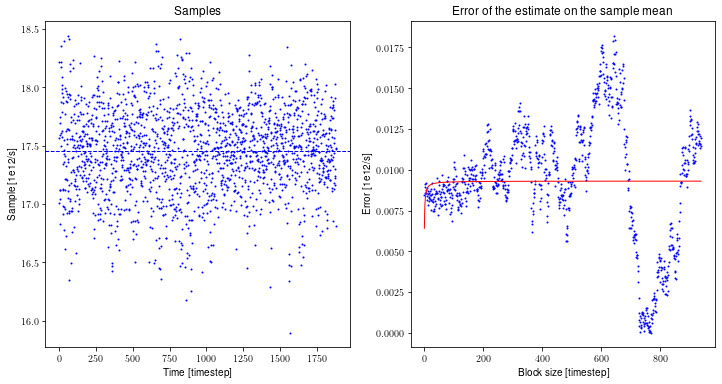

Rate factor with block averaging:
---------------------------------
  A = 17.454 +- 0.019 1e12*au/s (1880 TS samples, int. autocorr. time = 2.104 timesteps)



In [18]:
A, A_dist = rate.result_blav(plot=True, fitrange=[1,300])

In [19]:
rate_results = rate.compute_rate(fep, verbose=True)

k_F  = 7.194e+00 1e8/s
dF_F = 20.373 kJ/mol
k_B  = 7.014e+00 1e8/s
dF_B = 20.430 kJ/mol
